In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

Helpful functions:

In [3]:
def create_circle_pattern(matrix, row, col, radius):
    n = matrix.shape[0]
    x, y = np.ogrid[:n, :n]
    dist = np.sqrt((x-row)**2 + (y-col)**2)
    matrix[dist <= radius] = 1
    return matrix

In [4]:
# Constants / problem paramters
freq = 1e6              # Drive frequency
omega_rf = 2 * np.pi *freq
m = 40.077 / 1000 / 6.022e23 # [kg] molecular weight / Avogadro to get
q_e = 1.60218e-19       # [C] Charge 
r_0 = 10e-3             # [m] Radius of trap electrodes
V_dc = 0                # [V] DC voltage 
T = 1 / omega_rf        # [s] Period
T = 10

# Mathieu Equation

First, let's find stable solutions to Mathieu's equation

i=0 j=0
i=1 j=0
i=2 j=0
i=3 j=0
i=4 j=0
i=5 j=0
i=6 j=0
i=7 j=0
i=8 j=0
i=9 j=0
i=10 j=0
i=11 j=0
i=12 j=0
i=13 j=0
i=14 j=0
i=15 j=0
i=16 j=0
i=17 j=0
i=18 j=0
i=19 j=0
i=20 j=0
i=21 j=0
i=22 j=0
i=23 j=0
i=24 j=0
i=25 j=0
i=26 j=0
i=27 j=0
i=28 j=0
i=29 j=0
i=30 j=0
i=31 j=0
i=32 j=0
i=33 j=0
i=34 j=0
i=35 j=0
i=36 j=0
i=37 j=0
i=38 j=0
i=39 j=0
i=0 j=1
i=1 j=1
i=2 j=1
i=3 j=1
i=4 j=1
i=5 j=1
i=6 j=1
i=7 j=1
i=8 j=1
i=9 j=1
i=10 j=1
i=11 j=1
i=12 j=1
i=13 j=1
i=14 j=1
i=15 j=1
i=16 j=1
i=17 j=1
i=18 j=1
i=19 j=1
i=20 j=1
i=21 j=1
i=22 j=1
i=23 j=1
i=24 j=1
i=25 j=1
i=26 j=1
i=27 j=1
i=28 j=1
i=29 j=1
i=30 j=1
i=31 j=1
i=32 j=1
i=33 j=1
i=34 j=1
i=35 j=1
i=36 j=1
i=37 j=1
i=38 j=1
i=39 j=1
i=0 j=2
i=1 j=2
i=2 j=2
i=3 j=2
i=4 j=2
i=5 j=2
i=6 j=2
i=7 j=2
i=8 j=2
i=9 j=2
i=10 j=2
i=11 j=2
i=12 j=2
i=13 j=2
i=14 j=2
i=15 j=2
i=16 j=2
i=17 j=2
i=18 j=2
i=19 j=2
i=20 j=2
i=21 j=2
i=22 j=2
i=23 j=2
i=24 j=2
i=25 j=2
i=26 j=2
i=27 j=2
i=28 j=2
i=29 j=2
i=30 j=2
i=31 j=2
i=32 j=2
i=33 j=2
i=34

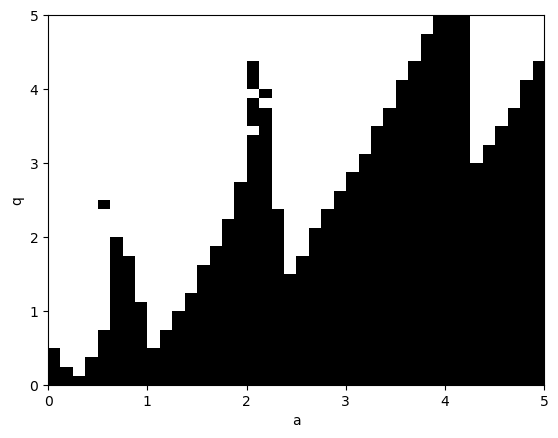

In [57]:
# Define the range of a and q values to plot
a_min = 0
a_max = 5
q_min = 0
q_max = 5
num_points = 40
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)



def mathieu_rk4(a,q,t,y1_0,y2_0):
    h = t[1]-t[0]

    tpoints = t

    r = np.zeros((len(t),2))
    r[0] =[y1_0,y2_0]

    for i,t in enumerate(tpoints[1:],1):
        k1 = h * mathieu(t,         r[i-1], a, q)
        k2 = h * mathieu(t+0.5*h,   r[i-1]+0.5*k1, a, q)
        k3 = h * mathieu(t+0.5*h,   r[i-1]+0.5*k2, a, q)
        k4 = h * mathieu(t+h,       r[i-1]+k3, a, q)
        r[i] = r[i-1] + (k1 + 2*k2 + 2*k3 + k4) / 6.0

    return r

def mathieu(t,r,a,q):
    y1, y2 = r
    dy1dt = y2
    dy2dt =  -(a + q * np.cos(t)) * y1
    return np.array([dy1dt,dy2dt])



# Define a function to check the stability of a given initial condition
def is_stable(a, q, tau, err):
    t_eval = np.linspace(0.0,tau,10000)
    x11 = odeint(mathieu, y0=[1.0, 0.0], t=t_eval, args=(a,q), tfirst=True)
    x22 = odeint(mathieu, y0=[0.0, 1.0], t=t_eval, args=(a,q), tfirst=True)

    x11 = x11[-1, 0]
    x22 = x22[-1, 1]
    
    return (np.abs(x11) + np.abs(x22)) < 2.0 + err

def is_stable2(a,q,tau, err):
    t_eval = np.linspace(0.0,tau,10000)
    x11 = mathieu_rk4(a,q,t_eval,y1_0=1.0,y2_0=0.0)
    x22 = mathieu_rk4(a,q,t_eval,y1_0=0.0,y2_0=1.0)

    x11 = x11[-1,0]
    x22 = x22[-1,1]
    return (np.abs(x11) + np.abs(x22)) < 2.0 + err
    
# Compute the stability for all values of a and q
truth_stability = np.zeros((num_points,num_points), float)


for j,q in enumerate(q_values):
    for i,a in enumerate(a_values):
        print("i={} j={}".format(i,j))
        
        if is_stable(a,q,tau=100, err = 10):
            truth_stability[j,i] = 1
        
# Plot the stability diagram
fig, ax = plt.subplots()
im = ax.imshow(truth_stability, extent=[a_min, a_max, q_min, q_max], origin='lower', cmap='gray_r', aspect='auto')
ax.set_xlabel('a')
ax.set_ylabel('q')
plt.show()

i=0 j=0
i=1 j=0
i=2 j=0
i=3 j=0
i=4 j=0
i=5 j=0
i=6 j=0
i=7 j=0
i=8 j=0
i=9 j=0
i=10 j=0
i=11 j=0
i=12 j=0
i=13 j=0
i=14 j=0
i=15 j=0
i=16 j=0
i=17 j=0
i=18 j=0
i=19 j=0
i=20 j=0
i=21 j=0
i=22 j=0
i=23 j=0
i=24 j=0
i=25 j=0
i=26 j=0
i=27 j=0
i=28 j=0
i=29 j=0
i=30 j=0
i=31 j=0
i=32 j=0
i=33 j=0
i=34 j=0
i=35 j=0
i=36 j=0
i=37 j=0
i=38 j=0
i=39 j=0
i=0 j=1
i=1 j=1
i=2 j=1
i=3 j=1
i=4 j=1
i=5 j=1
i=6 j=1
i=7 j=1
i=8 j=1
i=9 j=1
i=10 j=1
i=11 j=1
i=12 j=1
i=13 j=1
i=14 j=1
i=15 j=1
i=16 j=1
i=17 j=1
i=18 j=1
i=19 j=1
i=20 j=1
i=21 j=1
i=22 j=1
i=23 j=1
i=24 j=1
i=25 j=1
i=26 j=1
i=27 j=1
i=28 j=1
i=29 j=1
i=30 j=1
i=31 j=1
i=32 j=1
i=33 j=1
i=34 j=1
i=35 j=1
i=36 j=1
i=37 j=1
i=38 j=1
i=39 j=1
i=0 j=2
i=1 j=2
i=2 j=2
i=3 j=2
i=4 j=2
i=5 j=2
i=6 j=2
i=7 j=2
i=8 j=2
i=9 j=2
i=10 j=2
i=11 j=2
i=12 j=2
i=13 j=2
i=14 j=2
i=15 j=2
i=16 j=2
i=17 j=2
i=18 j=2
i=19 j=2
i=20 j=2
i=21 j=2
i=22 j=2
i=23 j=2
i=24 j=2
i=25 j=2
i=26 j=2
i=27 j=2
i=28 j=2
i=29 j=2
i=30 j=2
i=31 j=2
i=32 j=2
i=33 j=2
i=34

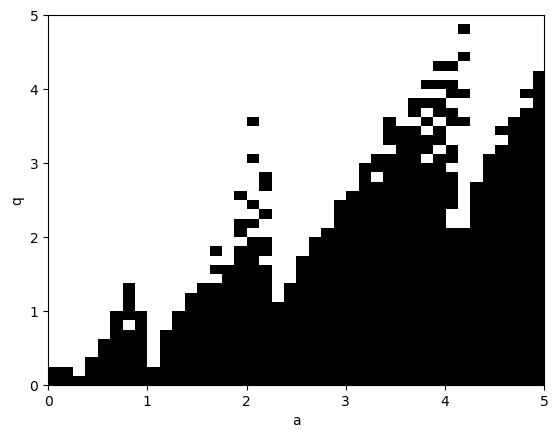

In [53]:
# Compute the stability for all values of a and q
calc_stability = np.zeros((num_points,num_points), float)


for j,q in enumerate(q_values):
    for i,a in enumerate(a_values):
        print("i={} j={}".format(i,j))
        if is_stable2(a,q,tau=100, err = .2):
            calc_stability[j,i] = 1
        
# Plot the stability diagram
fig, ax = plt.subplots()
im = ax.imshow(calc_stability, extent=[a_min, a_max, q_min, q_max], origin='lower', cmap='gray_r', aspect='auto')
ax.set_xlabel('a')
ax.set_ylabel('q')
plt.show()

Now that we know the regions of stability, we can choose adequate a and q parameters to have bounded motion. Here I use the RK4 method to numerically solve the equations for position and velocity of the particle in the trap.

nan
False


C:\Users\rmcgill9\AppData\Local\Temp\ipykernel_31100\2520742882.py:27: RuntimeWarning: overflow encountered in multiply
  k4 = h * mathieu(r[i-1]+k3, t+h, a, q)
C:\Users\rmcgill9\AppData\Local\Temp\ipykernel_31100\2520742882.py:25: RuntimeWarning: invalid value encountered in add
  k2 = h * mathieu(r[i-1]+0.5*k1, t+0.5*h, a, q)
C:\Users\rmcgill9\AppData\Local\Temp\ipykernel_31100\2520742882.py:26: RuntimeWarning: invalid value encountered in add
  k3 = h * mathieu(r[i-1]+0.5*k2, t+0.5*h, a, q)


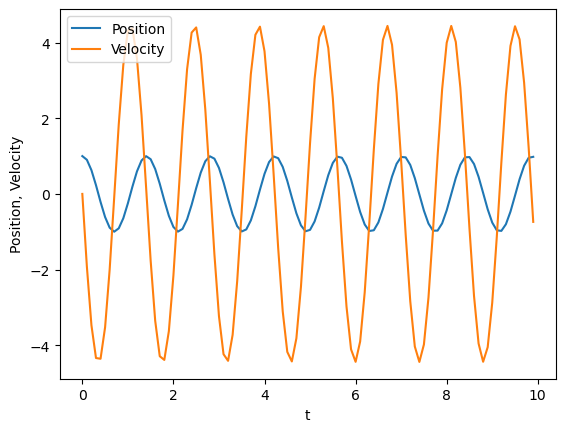

In [11]:
# Initial conditions
y1_0 = 1.0
y2_0 = 0.0
a = .1
q = 10

# Define Mathieu Equation
def mathieu(r,t,a,q):
    y1, y2 = r
    dy1dt = y2
    dy2dt =  (a - 2 * q * np.cos(omega_rf * 2 * t)) * y1
    return np.array([dy1dt,dy2dt])

T = 10
N = 100
h = T/N
tpoints = np.arange(0.0,T,h)
r = np.zeros((N,2))
r[0] =[y1_0,y2_0]

for i,t in enumerate(tpoints[1:],1):
    k1 = h * mathieu(r[i-1], t, a, q)
    k2 = h * mathieu(r[i-1]+0.5*k1, t+0.5*h, a, q)
    k3 = h * mathieu(r[i-1]+0.5*k2, t+0.5*h, a, q)
    k4 = h * mathieu(r[i-1]+k3, t+h, a, q)
    r[i] = r[i-1] + (k1 + 2*k2 + 2*k3 + k4) / 6.0

print(is_stable(a,q,y1_0,y2_0,tau=1000,N=N))

plt.plot(tpoints, r[:,0], label=r'Position')
plt.plot(tpoints, r[:,1], label=r'Velocity')
plt.xlabel("t")
plt.ylabel(r"Position, Velocity")
plt.legend()
plt.show()

# Electric field solutions:

In [ ]:
# Constants
M = 100             # Grid squares on a side


A = 35              # Electric field amplitude
rod_radius = 25

coords_pos = [[rod_radius+1,rod_radius+1],[M-rod_radius-1,M-rod_radius-1]]
coords_neg = [[M-rod_radius-1,rod_radius+1],[rod_radius+1,M-rod_radius-1]]
pos_bit_pattern = np.zeros([M+1,M+1])
neg_bit_pattern = np.zeros([M+1,M+1])
for row,col in coords_pos:
    pos_bit_pattern = create_circle_pattern(pos_bit_pattern,row,col,rod_radius)
for row,col in coords_neg:
    neg_bit_pattern = create_circle_pattern(neg_bit_pattern,row,col,rod_radius)
# Now we have an easy way to device the negative and positive voltages


In [ ]:
# Find the electrostatic field at the given time step.
# In time, we want to iterate over one period.
N = 10 # time steps
period = 1 / omega_rf

time_step = np.linspace(start=0.0,stop=period,num=N)
a = 1e-3 # 1mm spacing

# We will call our two rods by their initial voltage pattern
negvoltage = -A * np.cos(time_step * omega_rf)
posvoltage = A * np.cos(time_step * omega_rf)
# Make a cumulative average, or a total matrix
phi_all = np.zeros((N,M+1,M+1),dtype=float)
it = 0
# Eventually will loop, for now let's take a look at one stable solution
for t in time_step:
    target = 1e-6
    epsilon_0 = 8.85e-12


    phi = np.zeros([M+1,M+1], float)
    rho = np.zeros([M+1,M+1], float)
    rho = rho + neg_bit_pattern * negvoltage[it] + pos_bit_pattern * posvoltage[it]
    phi = phi + neg_bit_pattern * negvoltage[it] + pos_bit_pattern * posvoltage[it]
    phiprime = np.zeros([M+1,M+1], float)

    # Main loop
    delta = 1.0
    iteration = 0
    while delta>target:
        # Calculate new values of the potential
        phiprime[0,:] = phi[0,:]
        phiprime[-1,:] = phi[-1,:]
        phiprime[:,0] = phi[:,0]
        phiprime[:,-1] = phi[:,-1]


        phiprime[1:M,1:M] = 0.25 * (phi[2:,1:M] + phi[:M-1,1:M] + phi[1:M,2:] + phi[1:M,:M-1]) + \
            (0.25 * a**2 / epsilon_0) * rho[1:M,1:M]    
                                        
        # Calculate maximum fractional difference from old values
        delta = np.abs(phi-phiprime)
        nonzero = phi > 0
        if nonzero.any():

            delta = np.max(delta[nonzero])
        else:
            delta = 1.0
       

        # Swap the two arrays around
        phi,phiprime = phiprime,phi
        iteration += 1
    phi_all[it] = phi
    print(it)
    it += 1




In [ ]:
from PIL import Image, ImageDraw
from matplotlib import cm
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg


cmap = plt.get_cmap('seismic')

frames = []
for electric_field in phi_all:
    fig, ax = plt.subplots()
    im = ax.imshow(electric_field, cmap=cmap)
    # Add frame to list of frames
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    frame = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)
imageio.mimsave('efield.gif',frames,fps=10)